## Imports

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
import nltk
from nltk.corpus import stopwords
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import make_scorer, recall_score, confusion_matrix

RANDOM_STATE = 42

## Read-In Data

In [3]:
subreddits = pd.read_csv('../data/subreddits_preprocessed.csv')
subreddits.drop(columns = 'Unnamed: 0', inplace = True)

In [4]:
subreddits.head(2)

,subreddit,author,num_comments,score,timestamp,original_text,post_length_char,post_length_words,is_unethical,stemmer_text,polarity,sentiment_cat
0,LifeProTips,AlienAgency,2,1,2020-07-17,: Answers to why,16,4,0,: answer to whi,0.0,Neutral
1,LifeProTips,GarbageMiserable0x0,2,1,2020-07-17,¿Quieres obtener juegos y premios gratis en tu...,60,10,0,¿quier obten juego y premio grati en tu tiempo...,0.0,Neutral


## Model Preparation

In a separate set of models, I determined that stemmed text and the Tfidf Vectorizer would be a good choice for my data. Therefore, I will conduct a train test split on the stemmed text and set up a Column Transformer to only vectorize my text data.

### Train Test Split

In [5]:
features = ['num_comments', 'score', 'post_length_char', 'post_length_words', 'polarity', 'stemmer_text']
#features = ['stemmer_text']
X = subreddits[features]
y = subreddits['is_unethical']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = RANDOM_STATE, stratify = y)

#### Data for Multinomial Bayes Only

In [7]:
X_bayes = subreddits[['stemmer_text']]
y_bayes = subreddits['is_unethical']

In [8]:
X_bayes_train, X_bayes_test, y_bayes_train, y_bayes_test = train_test_split(X_bayes, y_bayes, test_size = 0.3, random_state = RANDOM_STATE, stratify = y)

### Define Stop Words Hyperparameter for Vectorizer

In [9]:
nltk_stopwords = stopwords.words('english') + stopwords.words('spanish')
custom_stop_words = nltk_stopwords + ['someon', 'll', 'like', 'know', 'ulpt', 'lpt', 'need', 'use', 'make', 'wa', 'way', 'peopl', 'ask', 'say', 'time', 'thi', 'want', 'work', 'just', 'start', 'ha', 'tri', 'becaus', 'onli', 'friend']

### Build Column Transformer to Only Apply Vectorizer to Text Features

In [10]:
tfidf_transformer = ColumnTransformer([
    ('tfidf', TfidfVectorizer(), 'stemmer_text'),], 
    remainder='passthrough')

## Modeling

MARKDOWN TO DESCRIBE THE PROCESS!

### Functions

In [11]:
def display_accuracy_scores(model, xtrain, ytrain, xtest, ytest):
    print(f'The cross validation accuracy score is {round(cross_val_score(model, xtrain, ytrain).mean(),4)}.')
    print(f'The training accuracy score is {round(model.score(xtrain, ytrain),4)}.')
    print(f'The testing accuracy score is {round(model.score(xtest, ytest),4)}.')

In [12]:
def display_accuracy_scores_gs(model, xtrain, ytrain, xtest, ytest):
    print(f'The training accuracy score is {round(model.score(xtrain, ytrain),4)}.')
    print(f'The testing accuracy score is {round(model.score(xtest, ytest),4)}.')

In [13]:
def display_cross_val_gs(model):
    print(f'The cross_val score is {round(model.best_score_, 4)}.')

In [14]:
def get_training_sensitivity(actual_values, predicted_values):
    tn, fp, fn, tp = confusion_matrix(actual_values, predicted_values).ravel()
    print(f'The training sensitivity score is {round(tp/(tp+fn), 4)}.')

In [15]:
def get_testing_sensitivity(actual_values, predicted_values):
    tn, fp, fn, tp = confusion_matrix(actual_values, predicted_values).ravel()
    print(f'The testing sensitivity score is {round(tp/(tp+fn), 4)}.')

### Model 1: Null Model

In [16]:
null = DummyClassifier(strategy = 'stratified', random_state = RANDOM_STATE) # Will respect training class distribution

In [17]:
null.fit(X_train, y_train);

#### Evaluate Accuracy and Sensitivity Metrics

*Accuracy*

In [18]:
display_accuracy_scores(null, X_train, y_train, X_test, y_test)

The cross validation accuracy score is 0.501.
The training accuracy score is 0.5051.
The testing accuracy score is 0.5006.


*Sensitivity*

In [19]:
get_training_sensitivity(y_train, null.predict(X_train))

The training sensitivity score is 0.5437.


In [20]:
get_testing_sensitivity(y_test, null.predict(X_test))

The testing sensitivity score is 0.5397.


The null model is making predictions in order to preserve the class distributions of the training set. In order to perform better than the null model, any models taht are built must perform better than 50.1% accuracy and ~54.0% sensitivity on the testing data.

### Model 2a: Logistic Regression with No Regularization

#### Create Pipeline

In [21]:
logreg_pipe = Pipeline([
    ('tfidf', tfidf_transformer),
    ('logreg', LogisticRegression(penalty = 'none', solver = 'newton-cg', max_iter = 600))
])

# The model would not converge for the other solvers. Newton-cg can be used to fit larger datasets.

#### Grid Search Over Pipeline

In [22]:
logreg_pipe_params = {
    'tfidf__tfidf__stop_words': [nltk_stopwords],
    'tfidf__tfidf__ngram_range': [(1,1)],
    'tfidf__tfidf__min_df': [6],
    'tfidf__tfidf__max_df': [0.25],
    'tfidf__tfidf__max_features': [750]
}

# Only best hyperparameters shown

In [23]:
gs_logreg_pipe = GridSearchCV(logreg_pipe, 
                              param_grid = logreg_pipe_params, 
                              cv = 5, 
                              verbose = 1, 
                              n_jobs = -1)

In [24]:
gs_logreg_pipe.fit(X_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.3s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.4s finished


#### Evaluate Accuracy Metric

*Accuracy*

In [25]:
display_cross_val_gs(gs_logreg_pipe)

The cross_val score is 0.7035.


In [26]:
display_accuracy_scores_gs(model = gs_logreg_pipe, xtrain = X_train, xtest = X_test, ytrain = y_train, ytest = y_test)

The training accuracy score is 0.8402.
The testing accuracy score is 0.7182.


*Sensitivity*

In [27]:
get_training_sensitivity(y_train, gs_logreg_pipe.predict(X_train))

The training sensitivity score is 0.8491.


In [28]:
get_testing_sensitivity(y_test, gs_logreg_pipe.predict(X_test))

The testing sensitivity score is 0.7422.


Although this model performs better than baseline accuracy, this model is extremely overfit, but this is likely due to the large number of features in the model without any regularization. (Note: In this model, there are 3035 features (3030 are words and 5 are numerical features).

### Model 2b: Logistic Regression with Regularization

#### Create Pipeline

In [29]:
logreg_reg_pipe = Pipeline([
    ('tfidf', tfidf_transformer),
    ('ss', StandardScaler(with_mean = False)),
    ('logreg', LogisticRegression(solver = 'liblinear'))])

#### Grid Search Over Pipeline

In [30]:
logreg_reg_pipe_params = {
    'tfidf__tfidf__stop_words': [custom_stop_words],
    'tfidf__tfidf__ngram_range': [(1,2)],
    'tfidf__tfidf__max_df': [0.65],
    'tfidf__tfidf__min_df': [2],
    'logreg__penalty': ['l2'],
    'logreg__C': [0.0001]
}
# Only best params remain in grid

In [31]:
gs_logreg_reg_pipe = GridSearchCV(logreg_reg_pipe, param_grid = logreg_reg_pipe_params, cv = 5, verbose=1, n_jobs = -1)

In [32]:
gs_logreg_reg_pipe.fit(X_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


#### Evaluate Accuracy Metric

*Accuracy*

In [33]:
display_cross_val_gs(gs_logreg_reg_pipe)

The cross_val score is 0.7644.


In [34]:
display_accuracy_scores_gs(model = gs_logreg_reg_pipe, xtrain = X_train, xtest = X_test, ytrain = y_train, ytest = y_test)

The training accuracy score is 0.9786.
The testing accuracy score is 0.783.


*Sensitivity*

In [35]:
get_training_sensitivity(y_train, gs_logreg_reg_pipe.predict(X_train))

The training sensitivity score is 0.9915.


In [36]:
get_testing_sensitivity(y_test, gs_logreg_reg_pipe.predict(X_test))

The testing sensitivity score is 0.8434.


### Model 3: Multinomial Naive Bayes

#### Create Pipe

In [37]:
nb_pipe = Pipeline([
    ('tfidf', tfidf_transformer),
    ('nb', MultinomialNB())
])

#### Grid Search Over Pipe

In [38]:
nb_pipe_params = {
    'tfidf__tfidf__stop_words': [nltk_stopwords],
    'tfidf__tfidf__min_df': [3],
    'tfidf__tfidf__max_df': [0.20],
    'tfidf__tfidf__ngram_range': [(1,2)],
    'tfidf__tfidf__max_features': [None]
}

In [39]:
gs_nb_pipe = GridSearchCV(nb_pipe, param_grid = nb_pipe_params, cv = 5, verbose = 1, n_jobs = -1)

In [40]:
gs_nb_pipe.fit(X_bayes_train, y_bayes_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


#### Evaluate Sensitivity Metric

*Accuracy*

In [41]:
display_cross_val_gs(gs_nb_pipe)

The cross_val score is 0.7717.


In [42]:
display_accuracy_scores_gs(gs_nb_pipe, X_bayes_train, y_bayes_train, X_bayes_test, y_bayes_test)

The training accuracy score is 0.9025.
The testing accuracy score is 0.7881.


*Sensitivity*

In [43]:
get_training_sensitivity(y_bayes_train, gs_nb_pipe.predict(X_bayes_train))

The training sensitivity score is 0.9543.


In [44]:
get_testing_sensitivity(y_bayes_test, gs_nb_pipe.predict(X_bayes_test))

The testing sensitivity score is 0.8831.


### Model 4: KNN

#### Create Pipe

In [45]:
knn_pipe_robust = Pipeline([
    ('tfidf', tfidf_transformer),
    ('rs', RobustScaler(with_centering = False)),
    ('knn', KNeighborsClassifier())
])

# In this case, robust scaler performed better than standard scaler

#### Grid Search Over Pipe

In [46]:
knn_pipe_params = {
    'tfidf__tfidf__stop_words':['english'],
    'tfidf__tfidf__min_df': [8],
    'tfidf__tfidf__max_df': [0.45],
    'tfidf__tfidf__ngram_range': [(1,1)],
    'knn__n_neighbors' : [20],
    'knn__metric':['euclidean'],
    'knn__weights': ['distance']    
}
# Only best params remain

In [47]:
gs_knn_pipe_robust = GridSearchCV(knn_pipe_robust, knn_pipe_params, cv = 5, verbose = 1, n_jobs = -1)

In [48]:
gs_knn_pipe_robust.fit(X_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


#### Evaluate Metrics

*Accuracy*

In [49]:
gs_knn_pipe_robust.best_score_

0.6683734886069932

In [50]:
display_accuracy_scores_gs(gs_knn_pipe_robust, X_train, y_train, X_test, y_test)

The training accuracy score is 1.0.
The testing accuracy score is 0.6494.


*Sensitivity*

In [51]:
get_training_sensitivity(y_train, gs_knn_pipe_robust.predict(X_train))

The training sensitivity score is 1.0.


In [52]:
get_testing_sensitivity(y_test, gs_knn_pipe_robust.predict(X_test))

The testing sensitivity score is 0.7568.


### Model 5: Decision Tree

#### Create Pipeline

In [53]:
dt_pipe = Pipeline([
    ('tfidf', tfidf_transformer),
    ('dt', DecisionTreeClassifier())
])

#### Grid Search Over Pipeline

In [54]:
dt_pipe_params = {
    'tfidf__tfidf__stop_words': ['english'],
    'tfidf__tfidf__min_df': [2],
    'tfidf__tfidf__max_df': [0.6],
    'tfidf__tfidf__ngram_range': [(1,2)],
    'dt__min_samples_split': [7],
    'dt__min_samples_leaf': [1],
    'dt__max_depth': [15]
}
# Only best params shown

In [55]:
gs_dt_pipe = GridSearchCV(dt_pipe, param_grid = dt_pipe_params, cv = 5, verbose = 1, n_jobs = -1)

In [56]:
gs_dt_pipe.fit(X_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


In [57]:
gs_dt_pipe.best_params_

{'dt__max_depth': 15,
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 7,
 'tfidf__tfidf__max_df': 0.6,
 'tfidf__tfidf__min_df': 2,
 'tfidf__tfidf__ngram_range': (1, 2),
 'tfidf__tfidf__stop_words': 'english'}

#### Evaluate Metrics

*Accuracy*

In [58]:
display_cross_val_gs(gs_dt_pipe)

The cross_val score is 0.6913.


In [59]:
display_accuracy_scores_gs(gs_dt_pipe, X_train, y_train, X_test, y_test)

The training accuracy score is 0.778.
The testing accuracy score is 0.6812.


*Sensitivity*

In [60]:
get_training_sensitivity(y_train, gs_dt_pipe.predict(X_train))

The training sensitivity score is 0.6516.


In [61]:
get_testing_sensitivity(y_test, gs_dt_pipe.predict(X_test))

The testing sensitivity score is 0.5752.


### Model 6: Bagging Classifier

#### Create Pipe

In [62]:
bag_pipe = Pipeline([
    ('tfidf', tfidf_transformer),
    ('bc', BaggingClassifier(random_state = RANDOM_STATE))
])

In [63]:
bag_pipe_params = {
    'tfidf__tfidf__stop_words':['english'],
    'tfidf__tfidf__min_df': [2],
    'tfidf__tfidf__max_df': [0.6],
    'tfidf__tfidf__ngram_range': [(1,2)],
    'bc__n_estimators':[100]
}

In [64]:
gs_bag_pipe = GridSearchCV(bag_pipe, param_grid = bag_pipe_params, cv = 5, verbose = 1, n_jobs = -1)

In [65]:
gs_bag_pipe.fit(X_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   31.3s remaining:   47.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.5s finished


In [66]:
gs_bag_pipe.best_params_

{'bc__n_estimators': 100,
 'tfidf__tfidf__max_df': 0.6,
 'tfidf__tfidf__min_df': 2,
 'tfidf__tfidf__ngram_range': (1, 2),
 'tfidf__tfidf__stop_words': 'english'}

#### Evaluate Metrics

*Accuracy*

In [67]:
display_cross_val_gs(gs_bag_pipe)

The cross_val score is 0.7441.


In [68]:
display_accuracy_scores_gs(gs_bag_pipe, X_train, y_train, X_test, y_test)

The training accuracy score is 1.0.
The testing accuracy score is 0.7489.


*Sensitivity*

In [69]:
get_testing_sensitivity(y_train, gs_bag_pipe.predict(X_train))

The testing sensitivity score is 1.0.


In [70]:
get_testing_sensitivity(y_test, gs_bag_pipe.predict(X_test))

The testing sensitivity score is 0.7422.


### Model 7: Random Forest

#### Create Pipe

In [93]:
rf_pipe = Pipeline([
    ('tfidf', tfidf_transformer),
    ('forest', RandomForestClassifier(random_state = 2020))
])

#### Grid Search Over Pipe

In [94]:
rf_pipe_params = {
    'tfidf__tfidf__stop_words' : ['english'],
    'tfidf__tfidf__min_df': [12],
    'tfidf__tfidf__max_df': [0.4],
    'tfidf__tfidf__ngram_range': [(1,2)],
    'forest__criterion': ['entropy'],
    'forest__max_depth': [12],
    'forest__ccp_alpha' : [0.001]
}

In [95]:
gs_rf_pipe = GridSearchCV(rf_pipe, param_grid = rf_pipe_params, cv = 5, verbose = 1, n_jobs = -1)

In [96]:
gs_rf_pipe.fit(X_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


In [97]:
rf_feature_names = gs_rf_pipe.best_estimator_.steps[0][1].transformers_[0][1].get_feature_names()

rf_feature_importances = gs_rf_pipe.best_estimator_.steps[1][1].feature_importances_

#### Evaluate Metrics

*Accuracy*

In [99]:
display_cross_val_gs(gs_rf_pipe)

The cross_val score is 0.7232.


In [100]:
display_accuracy_scores_gs(gs_rf_pipe, X_test, y_test, X_train, y_train)

The training accuracy score is 0.6932.
The testing accuracy score is 0.7717.


*Sensitivity*

In [101]:
get_training_sensitivity(y_train, gs_rf_pipe.predict(X_train))

The training sensitivity score is 0.9687.


In [102]:
get_training_sensitivity(y_test, gs_rf_pipe.predict(X_test))

The training sensitivity score is 0.9165.


### Model 8: Voting Classifier

In [105]:
voting = VotingClassifier(
    estimators = [
    ('logreg', gs_logreg_reg_pipe),
    ('dt', gs_dt_pipe),
    ('bagging', gs_bag_pipe),
    ('forest', gs_rf_pipe)
])
# Multinomial Bayes not included in vote because of incompatible data (negative values for polarity)

In [106]:
voting.fit(X_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   31.2s remaining:   46.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


In [ ]:
voting.score(X_train, y_train)

In [ ]:
voting.score(X_test, y_test)

In [ ]:
get_training_sensitivity(y_train, voting.predict(X_train))

In [ ]:
get_testing_sensitivity(y_test, voting.predict(X_test))

### Random Forest

In [114]:
tfidf_feature_names = gs_rf_pipe.best_estimator_.steps[0][1].transformers_[0][1].get_feature_names()

In [110]:
rf_feature_importances = gs_rf_pipe.best_estimator_.steps[1][1].feature_importances_

In [119]:
rf_feature_names = ['num_comments', 'score', 'post_length_char', 'post_length_words', 'polarity'] + tfidf_feature_names

In [129]:
rf_vocabulary = gs_rf_pipe.best_estimator_.steps[0][1].transformers_[0][1].vocabulary_

In [140]:
sorted_rf_vocab = {k:v for k,v in sorted(rf_vocabulary.items(), key=lambda item:item[1], reverse = True)}
# https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value

In [126]:
feature_importances_df = pd.DataFrame({'Feature':rf_feature_names, 'Importance':rf_feature_importances}).sort_values('Importance', ascending = False)

In [147]:
feature_importances_df[:30]

,Feature,Importance
485,forev,0.073465
1358,year ago,0.070263
681,letter,0.021653
437,eye,0.017503
127,batteri,0.017432
454,favorit,0.017141
1252,type,0.016603
568,hear,0.016320
1297,wall,0.014205
1359,young,0.013422


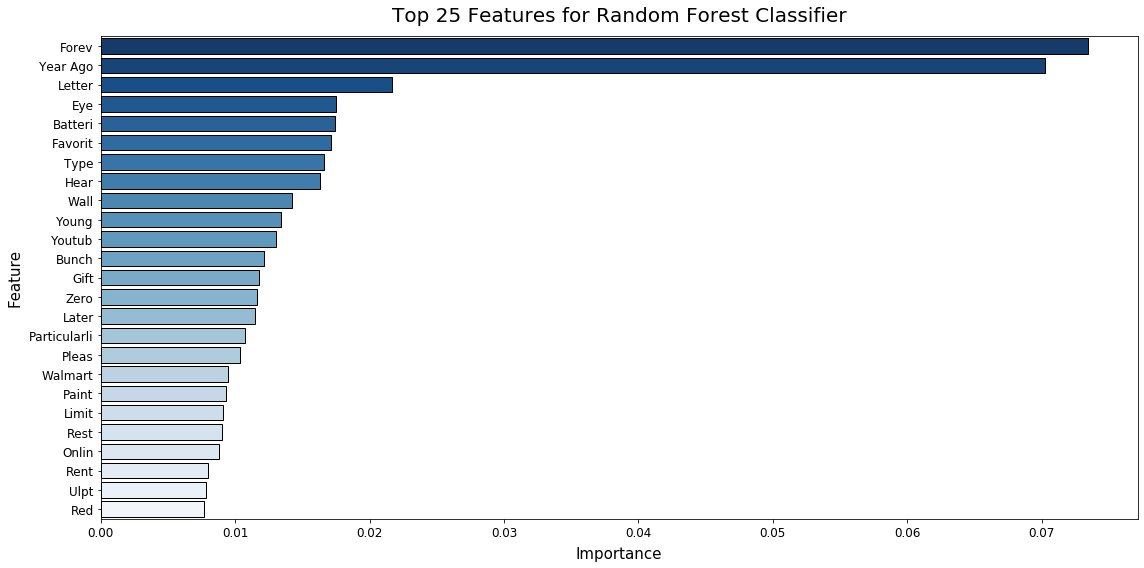

In [185]:
plt.figure(figsize = (16, 8))
sns.barplot(x = feature_importances_df['Importance'][:25], y = feature_importances_df['Feature'].str.title()[:25], orient='h', palette = 'Blues_r', edgecolor = 'black');
plt.title('Top 25 Features for Random Forest Classifier', fontdict = {'fontsize':20}, pad = 15)
plt.xlabel('Importance', fontdict = {'fontsize':15}, labelpad = 7)
plt.ylabel('Feature', fontdict = {'fontsize':15}, labelpad = 7)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout();